<a href="https://colab.research.google.com/github/coddy666/CODTECH-INTERNSHIP/blob/main/neural_style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torchvision matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 69.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 37.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 107.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.utils as utils

from PIL import Image
import matplotlib.pyplot as plt

import copy


In [5]:
from google.colab import files
uploaded = files.upload()

Saving img2.jpg to img2.jpg
Saving img5.jpg to img5.jpg


In [10]:
# Automatically detect uploaded filenames
file_list = list(uploaded.keys())
content_img_path = file_list[0]
style_img_path = file_list[1]


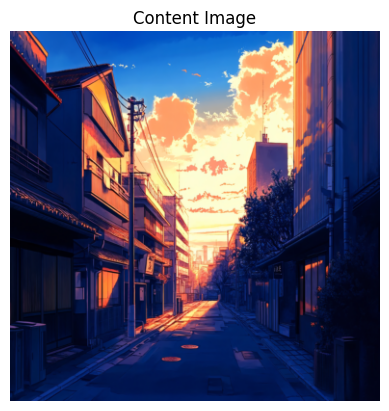

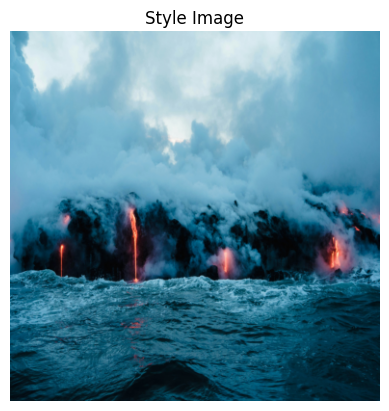

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_image(img_path, img_size=(384, 384)):
    image = Image.open(img_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor()
    ])
    image = transform(image).unsqueeze(0)
    return image.to(device, torch.float)

# Load both images with same size
content = load_image(content_img_path)
style = load_image(style_img_path)

# Show both images
def imshow(tensor, title=None):
    image = tensor.cpu().clone().squeeze(0)
    image = transforms.ToPILImage()(image)
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

imshow(content, title='Content Image')
imshow(style, title='Style Image')


In [12]:
class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, x):
        self.loss = nn.functional.mse_loss(x, self.target)
        return x

def gram_matrix(input):
    b, c, h, w = input.size()
    features = input.view(b * c, h * w)
    G = torch.mm(features, features.t())
    return G.div(b * c * h * w)

class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, x):
        G = gram_matrix(x)
        self.loss = nn.functional.mse_loss(G, self.target)
        return x

In [13]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

# Normalization values for VGG
normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super().__init__()
        self.mean = mean.view(-1, 1, 1)
        self.std = std.view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std

content_layers = ['conv_4']
style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, norm_mean, norm_std, style_img, content_img):
    cnn = copy.deepcopy(cnn)
    norm = Normalization(norm_mean, norm_std).to(device)

    content_losses = []
    style_losses = []

    model = nn.Sequential(norm)
    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = f'conv_{i}'
        elif isinstance(layer, nn.ReLU):
            name = f'relu_{i}'
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = f'pool_{i}'
        elif isinstance(layer, nn.BatchNorm2d):
            name = f'bn_{i}'
        else:
            continue

        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module(f"content_loss_{i}", content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module(f"style_loss_{i}", style_loss)
            style_losses.append(style_loss)

    # Trim the model after the last content/style loss
    for j in range(len(model) - 1, -1, -1):
        if isinstance(model[j], ContentLoss) or isinstance(model[j], StyleLoss):
            break
    model = model[:j+1]

    return model, style_losses, content_losses


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Step 50:
Style Loss: 0.0001, Content Loss: 22.8738
Step 100:
Style Loss: 0.0000, Content Loss: 20.9552
Step 150:
Style Loss: 0.0000, Content Loss: 17.1109
Step 200:
Style Loss: 0.0000, Content Loss: 14.9565
Step 250:
Style Loss: 0.0000, Content Loss: 13.8488
Step 300:
Style Loss: 0.0000, Content Loss: 13.1874


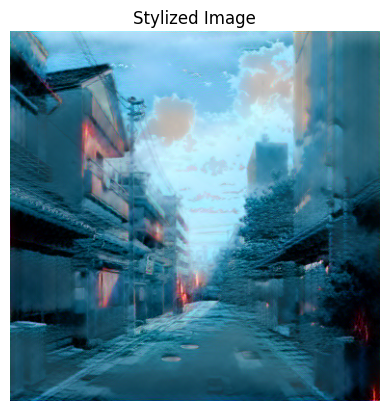

In [14]:
input_img = content.clone()

model, style_losses, content_losses = get_style_model_and_losses(
    cnn, normalization_mean, normalization_std, style, content
)

input_img.requires_grad_(True)
optimizer = optim.LBFGS([input_img])

run = [0]
while run[0] <= 300:

    def closure():
        input_img.data.clamp_(0, 1)

        optimizer.zero_grad()
        model(input_img)
        style_score = sum(sl.loss for sl in style_losses)
        content_score = sum(cl.loss for cl in content_losses)

        loss = style_score * 1e6 + content_score
        loss.backward()

        run[0] += 1
        if run[0] % 50 == 0:
            print(f"Step {run[0]}:")
            print(f"Style Loss: {style_score.item():.4f}, Content Loss: {content_score.item():.4f}")

        return loss

    optimizer.step(closure)

input_img.data.clamp_(0, 1)
imshow(input_img, title="Stylized Image")